In [1]:
import numpy as np
import matplotlib.pyplot as plt
import struct
from scipy import signal, fft
import timeit

In [2]:
# Message specification
fs = 8e6
sps = 4
Ts = 1/(fs/sps)

print(f"Symbol Time {Ts} and Symbol Freq {1/Ts}")

preamble = 0xAAAA
syncword = 0xD7     #Look at gold and hadamard codes

Symbol Time 5e-07 and Symbol Freq 2000000.0


In [3]:
def packetize(preamble, syncword, data):
    output = struct.pack("<HBB", preamble, syncword, len(data)) + bytes(data, 'utf-8')
    output = np.frombuffer(output, np.uint8)
    return output

In [4]:
packet = packetize(preamble, syncword, "Hello")
print(packet)

[170 170 215   5  72 101 108 108 111]


In [5]:
def unpack_bits(packet, sps):
    #create bit string
    bit_array = np.unpackbits(packet, bitorder='big')
    return np.repeat(bit_array, sps)
unpacked = unpack_bits(packet, sps)

In [32]:
def psk_mod(data, symbol_map):
    return symbol_map[data]

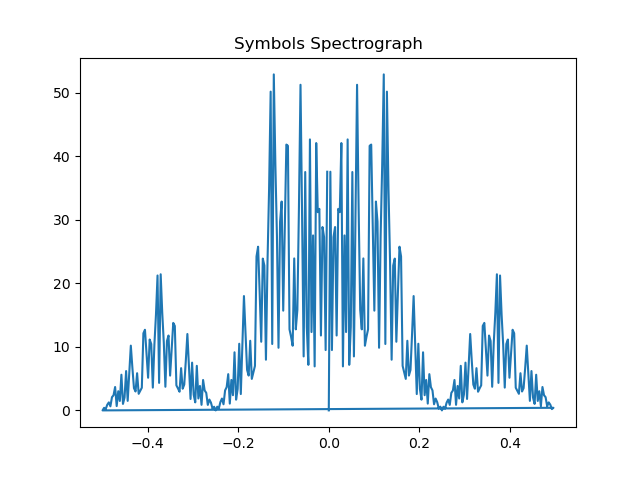

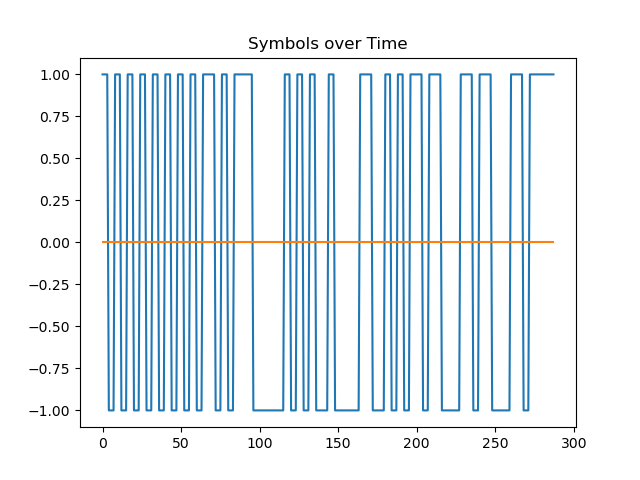

In [31]:
#bpsk_symbol_dict = {0:-1+0j, 1:1+0j}
bpsk_symbol_map = np.array([-1+0j, 1+0j])
symbols = psk_mod(unpacked, bpsk_symbol_map)

%matplotlib widget
plt.figure("Symbols over Time")
plt.title("Symbols over Time")
plt.plot(symbols.real)
plt.plot(symbols.imag)
plt.show

yf = fft.fft(symbols)
freqs = fft.fftfreq(symbols.size)

plt.figure("Symbols Spectrograph")
plt.title("Symbols Spectrograph")
plt.plot(freqs, np.abs(yf))
plt.show()

## Root Raised Cosine Filter
You can see that from the Symbols Spectrograph that the frequency response of this signal occupies a large bandwidth with the center lobe going from -1Mhz to +1Mhz. This corelates to -1/Ts and +1/Ts. As a result we should filter frequencies greater than +/- 1/Ts. 

The raised cosine filter does this. The RRC is derived from the sinc function (boxcar filter) and consists of 1/2 cylces of cos on either side. 

The raised cos filter is designed such that it decays to 0 in the time domain with minimal number of taps. 


63
Tsymbol 4


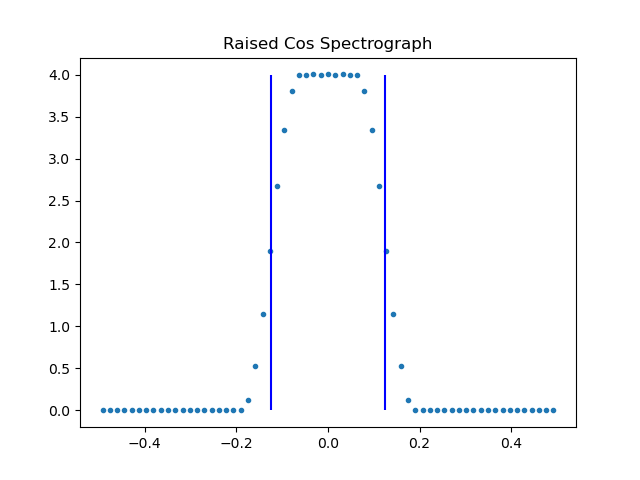

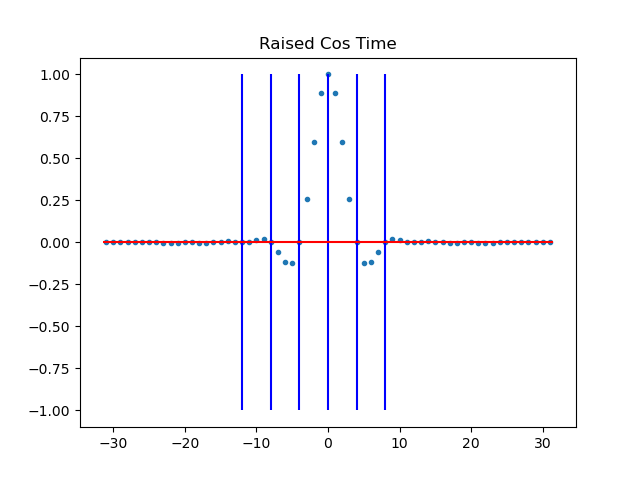

In [33]:
#Design Raised Cosine filter

ntaps = 16*sps - 1
print(ntaps)
n = np.arange(ntaps) - (ntaps-1)//2
beta = .51
Tsymbol = sps
print(f"Tsymbol {Tsymbol}")

if Tsymbol/(2*beta) in n:
    print("Filter has a tap that will result in divide by zero error")
    print(np.where(n==T/(2*beta)))
else:
    root_raised = np.cos(np.pi*beta*n/Tsymbol)*np.sinc(n/Tsymbol)/(1-(2*beta*n/Tsymbol)**2)



%matplotlib widget
plt.figure("Raised Cos over Time")
plt.title("Raised Cos Time")
plt.plot(n, root_raised, '.')
plt.vlines(np.arange(-3*sps, 3*sps, sps), -1, 1, 'b')
plt.hlines(0, -ntaps/2, ntaps/2, 'r')
plt.show

yf = fft.fft(root_raised)
freqs = fft.fftfreq(root_raised.size)

plt.figure("Raised Cos Spectrograph")
plt.title("Raised Cos Spectrograph")
plt.plot(freqs, np.abs(yf), '.')
plt.vlines([1/sps/2, -1/sps/2], 0, 4, 'b')
plt.show()

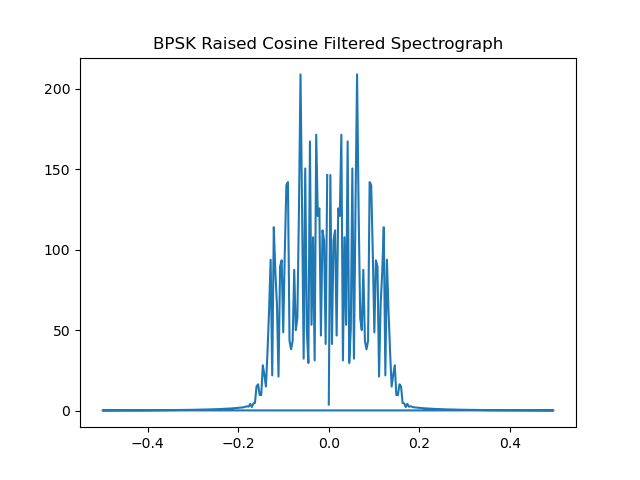

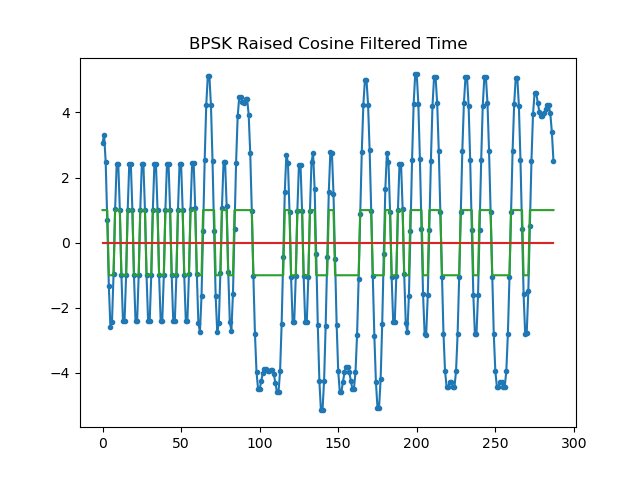

In [9]:
#Now try it on the modulated signal and see what happens
raised_cos_filtered = signal.convolve(symbols, root_raised, mode='same')


%matplotlib widget
plt.figure("BPSK Raised Cosine Filtered Time")
plt.title("BPSK Raised Cosine Filtered Time")
plt.plot(raised_cos_filtered.real, '.-')
plt.plot(raised_cos_filtered.imag)
plt.plot(symbols.real)
plt.plot(symbols.imag)

plt.show

yf = fft.fft(raised_cos_filtered)
freqs = fft.fftfreq(raised_cos_filtered.size)

plt.figure("BPSK Raised Cosine Filtered Spectrograph")
plt.title("BPSK Raised Cosine Filtered Spectrograph")
plt.plot(freqs, np.abs(yf))
plt.show()

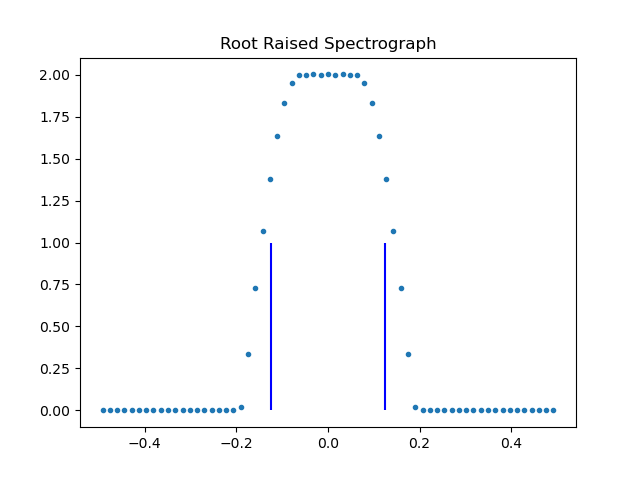

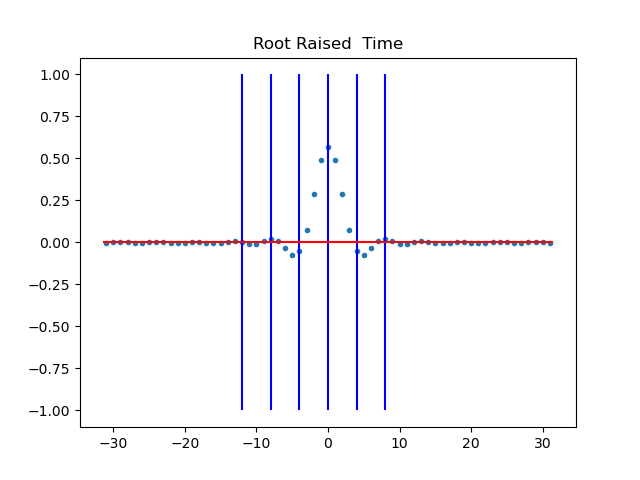

In [10]:
# Now make the raised cosine filter. This is done to create a matched filter for the tx and rx sides. 
def rootRaisedCos(ntaps, sps, excess_bw):
    n = np.arange(ntaps) - (ntaps-1)//2

    #avoid divide by 0 issue in rrc equation
    while sps/(4*excess_bw) in n:
        excess_bw += .001

    a = excess_bw
    
    #Gracefully ignore divide by 0 when n=0
    with np.errstate(divide='ignore', invalid='ignore'):
        rrc = np.cos(np.pi*(1+a)*n/sps) + sps/(4*a*n) * np.sin(np.pi*(1-a)*n/sps)
        rrc *= 4*a/(np.pi*np.sqrt(sps)) / (1 - (4*a*n/sps)**2)
        
    #Handle divide by zero condition when n=0
    rrc[np.argwhere(np.isnan(rrc))] = (1+a*(4/np.pi-1))/np.sqrt(sps)
    
    return n, rrc

n, rrc = rootRaisedCos(ntaps, sps, .51)

%matplotlib widget
plt.figure("Root Raised over Time")
plt.title("Root Raised  Time")
plt.plot(n, rrc, '.')
plt.vlines(np.arange(-3*sps, 3*sps, sps), -1, 1, 'b')
plt.hlines(0, -ntaps/2, ntaps/2, 'r')
plt.show

yf = fft.fft(rrc)
freqs = fft.fftfreq(rrc.size)

plt.figure("Root Raised Spectrograph")
plt.title("Root Raised Spectrograph")
plt.plot(freqs, np.abs(yf), '.')
plt.vlines([1/sps/2, -1/sps/2], 0, 1, 'b')
plt.show()

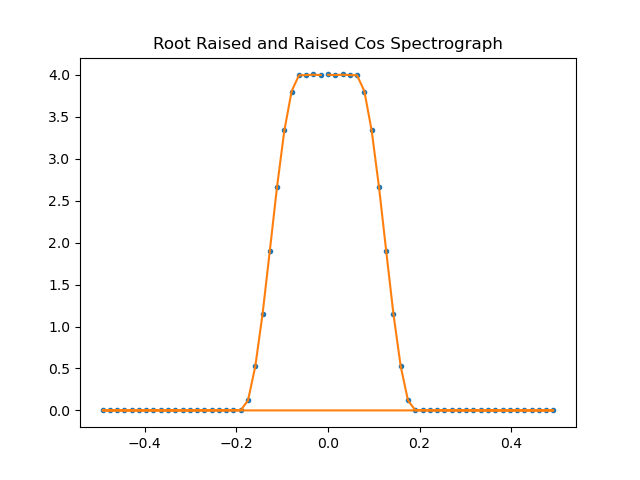

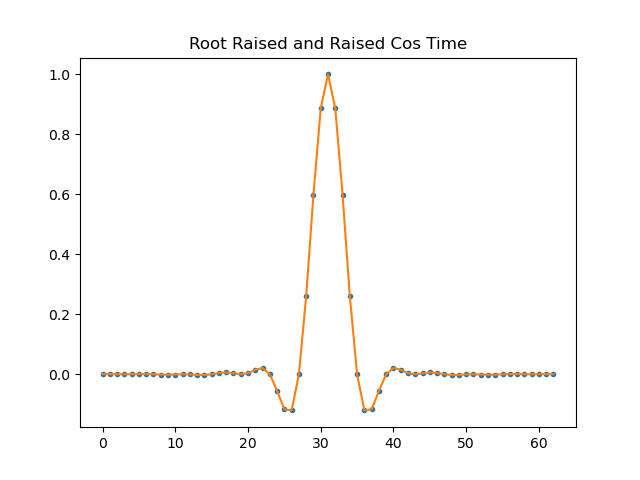

In [11]:
#Verify that 2 RRC is equal to a raised cos filter. This is to check that the algorithm is correct
rrc2 = signal.convolve(rrc, rrc, mode='same')

%matplotlib widget
plt.figure("Root Raised and Raised Cos over Time")
plt.title("Root Raised and Raised Cos Time")
plt.plot(rrc2, '.')
plt.plot(root_raised, '-')
plt.show

yf_rrc2 = fft.fft(rrc2)
freqs_rrc2 = fft.fftfreq(rrc2.size)

yf_rc = fft.fft(root_raised)
freqs_rc = fft.fftfreq(root_raised.size)

plt.figure("Root Raised and Raised Cos Spectrograph")
plt.title("Root Raised and Raised Cos Spectrograph")
plt.plot(freqs_rrc2, np.abs(yf_rrc2), '.')
plt.plot(freqs_rc, np.abs(yf_rc), '-')
#plt.vlines([1/sps/2, -1/sps/2], 0, 1, 'b')
plt.show()



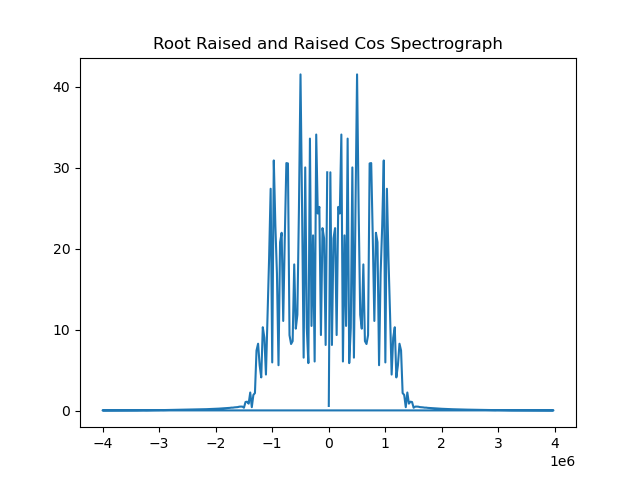

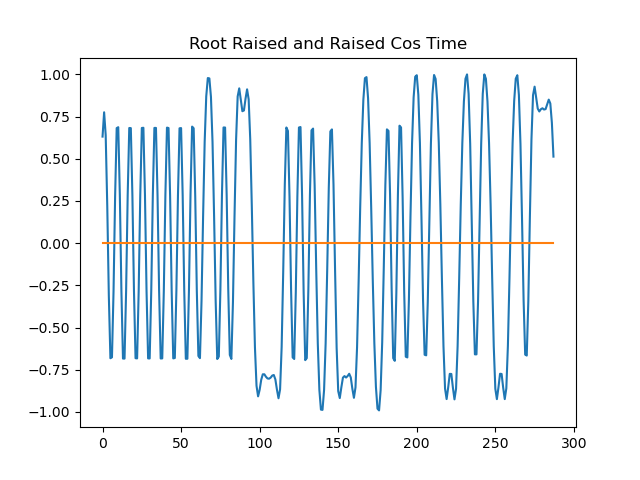

In [126]:
# apply RRC to modulated signal. This is the transmitted signal.
#symbols2 = np.concatenate([np.zeros(500*2), symbols, np.zeros(500*2)])
tx_waveform = signal.convolve(symbols, rrc, mode='same')
tx_waveform /= np.max(np.abs(tx_waveform))

%matplotlib widget
plt.figure("Root Raised and Raised Cos over Time")
plt.title("Root Raised and Raised Cos Time")
plt.plot(tx_waveform.real)
plt.plot(tx_waveform.imag)
plt.show

yf = fft.fft(tx_waveform)
freqs = fft.fftfreq(tx_waveform.size, d=1/fs)

plt.figure("Root Raised and Raised Cos Spectrograph")
plt.title("Root Raised and Raised Cos Spectrograph")
plt.plot(freqs, np.abs(yf))
plt.show()

## Channel Modeling
Now that we have the transmit waveform, we need to model how the signal will look like once it arrives at the receiver. The following factors need to be taken into account:
1. Additive White Gaussian Noise (AWGN). Take a signal to noise parameter to determine how much noise to add
2. Frequency offset. This is to model clock disparaties b/t the transmitter and receiver.
3. Phase offset. The signal will arrive at the receiver at an unknown period in time

Tx Variance 0.4301289693725654
Max Noise voltage so that SNR < 10dB 0.04301289693725654
63
Noise power: 0.9942928450731148


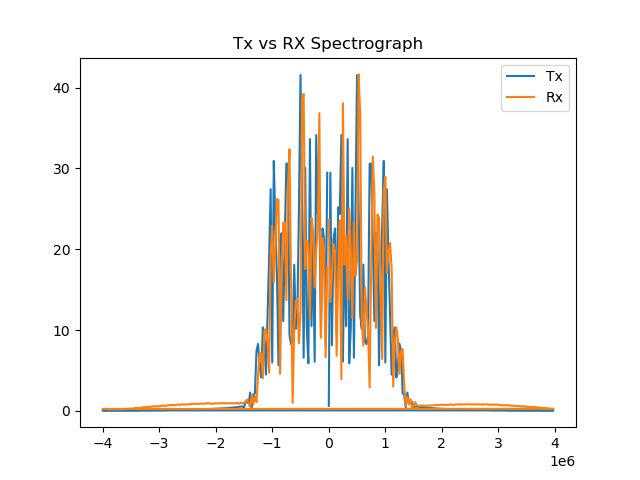

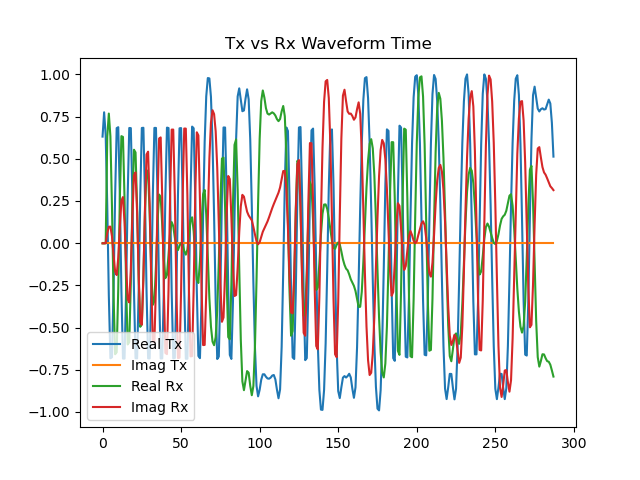

In [132]:
# Model Channel
def channel_model(input_sig, noise_voltage, fractional_samp_delay, samp_rate, freq_offset, padding):
    
    #Add fractional sample delay/phase offset using Whittaker–Shannon interpolation formula (https://tomroelandts.com/articles/how-to-create-a-fractional-delay-filter)
    N = 2**6 - 1 # Number of taps. This number was semi-arbitrarily picked 
    print(N)
    n = np.arange(-N//2, N//2) # 0 Center taps
    h = np.sinc(n-fractional_samp_delay)
    h *= np.hamming(N) #Window filter to ensure it decays to 0
    h /= np.sum(h)     #Normalize filter so there's 0dB gain

    phase_shifted = signal.convolve(input_sig, h, mode='same')

    # Frequency offset
    t = np.linspace(0, 1/samp_rate*len(input_sig), len(input_sig))
    freq_shifted = phase_shifted * np.exp(2j*np.pi*freq_offset*t)

    #Add AWGN
    noise = (np.random.randn(len(freq_shifted)) + 1j*np.random.randn(len(freq_shifted)))/np.sqrt(2)
    print(f"Noise power: {np.var(noise)}")
    output_sig = freq_shifted + noise_voltage*noise
    
    return output_sig



print(f"Tx Variance {np.var(tx_waveform)}")
max_noise = np.var(tx_waveform)/(10)
print(f"Max Noise voltage so that SNR < 10dB {max_noise}")

rx_waveform = channel_model(tx_waveform, max_noise**2, 2, fs, 40e3, 0)

%matplotlib widget
plt.figure("Tx vs Rx Waveform Time")
plt.title("Tx vs Rx Waveform Time")
plt.plot(tx_waveform.real)
plt.plot(tx_waveform.imag)
plt.plot(rx_waveform.real)
plt.plot(rx_waveform.imag)

plt.legend(['Real Tx', 'Imag Tx', 'Real Rx', 'Imag Rx'])
plt.show

rx_yf = fft.fft(rx_waveform)
rx_freqs = fft.fftfreq(rx_waveform.size, d=1/fs)

tx_yf = fft.fft(tx_waveform)
tx_freqs = fft.fftfreq(tx_waveform.size, d=1/fs)

plt.figure("Tx vs RX Spectrograph")
plt.title("Tx vs RX Spectrograph")
plt.plot(tx_freqs, np.abs(tx_yf))
plt.plot(rx_freqs, np.abs(rx_yf))
plt.legend(['Tx', 'Rx'])
plt.show()


## Demodulate
Demodulation will consist of 
1. Apply Root Raised Cosine Filter (LPF & Matched Filter)
2. Coarse Frequency Syncronization
3. Symbol syncronization / Burst Detection
4. Fine Frequency Syncronization
5. Demodulation
6. De-packitization 

In [ ]:
#Demodulate
def psk_demod(